# Context Offloading & Virtual File System

**Context Offloading** 기법을 활용하여 에이전트의 컨텍스트 윈도우를 효율적으로 관리하고, 가상 파일 시스템을 구축하는 방법을 다룹니다.

![](assets/agent_header_files.png)

**🏆 핵심 내용**

*   **Context Offloading**: 파일 시스템을 활용한 효율적인 컨텍스트 관리 전략
*   **Virtual File System**: LangGraph State 내 가상 파일 시스템 설계 및 구현
*   **File Tools**: `ls`, `read_file`, `write_file` 도구 개발 및 프롬프트 설계
*   **State & Reducer**: 파일 시스템 통합 및 Reducer를 통한 상태 병합 원리
*   **실습**: 연구 에이전트 예제를 통한 Context Offloading 적용

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## Context 부하를 줄여주는 방법론: Filesystem 을 활용한 Context Offloading

**Context Offloading**은 복잡한 작업 시 급격히 증가하는 Context Window 문제를 해결하기 위해, 중요 정보를 파일 시스템에 저장하고 필요 시 로드하는 전략입니다.

*   **필요성**: 다수의 Tool 호출로 인한 Context 누적 및 비용 증가 방지
*   **활용 사례**:
    *   [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus): 메모리 관리 최적화
    *   [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research): 대규모 연구 작업 지원
    *   [Anthropic Multi-agent System](https://www.anthropic.com/engineering/multi-agent-research-system): Subagent 간 정보 왜곡 방지 및 효율적 정보 공유
*   **장점**:
    *   메모리 효율성 증대
    *   구조화된 결과물(코드, 보고서 등)의 안정적 보존
    *   장기 작업 시 중간 결과 유지 및 재활용 용이

## File Tools 구현

LangGraph State 내에서 동작하는 **가상 파일 시스템(Virtual File System)** 도구를 구현합니다.

*   **구조**: `dict` 기반 (Key: 파일 경로, Value: 파일 내용)
*   **특징**: 단일 대화 스레드 내 단기 정보 보존에 최적화
*   **구현 도구**:
    *   `ls`: 파일 목록 조회
    *   `read_file`: 파일 내용 읽기 (Pagination 지원)
    *   `write_file`: 파일 생성 및 덮어쓰기
*   **동작 방식**: `Command` 타입을 활용한 Agent State 업데이트

In [2]:
# 프롬프트 출력 함수 호출을 위한 유틸리티 함수 임포트
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

# 파일 목록 조회도구 프롬프트
show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

에이전트 상태에 저장된 가상 파일시스템의 모든 파일 목록 조회

다른 파일 작업 수행 전 현재 에이전트 메모리에 존재하는 파일 확인 용도. 파일 구성 현황 파악에 활용.

파라미터 불필요 - ls() 호출만으로 모든 사용 가능한 파일 조회 가능.

In [3]:
# 파일 내용 읽기도구 프롬프트
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

가상 파일시스템에서 파일 내용 읽기 (선택적 페이지네이션 지원)

`cat -n`과 같이 라인 번호가 포함된 파일 내용 반환. 컨텍스트 오버플로우 방지를 위해 대용량 파일 청크 단위 읽기 지원.

파라미터:

- file_path (필수): 읽을 파일 경로
- offset (선택, 기본값=0): 읽기 시작 라인 번호
- limit (선택, 기본값=2000): 읽을 최대 라인 수

수정 전 기존 내용 파악 필수. 편집 전 반드시 파일 읽기 선행.

**중요 인사이트**

1. 파일 전체를 읽어 오는 것이 아닌, 일부를 읽어오는 방식을 택함
2. 순차적으로 `offset` 부터 `limit` 만큼 읽어오는 방식을 택함

![](assets/context_offloading.png)

In [4]:
# 파일 쓰기도구 프롬프트
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

가상 파일시스템에 새 파일 생성 또는 기존 파일 전체 덮어쓰기

새 파일 생성 또는 파일 내용 전체 교체 용도. 초기 파일 생성 또는 전체 재작성 시 사용. 파일은 에이전트 상태에 영구 저장.

파라미터:

- file_path (필수): 파일 생성/덮어쓰기 경로
- content (필수): 파일에 작성할 전체 내용

주의: 파일 내용 전체 교체됨.

## State & Reducer 정의

`DeepAgentState`와 `file_reducer`를 통해 파일 시스템의 상태를 관리하고 병합하는 메커니즘을 설명합니다.

*   **`DeepAgentState`**:
    *   `files`: 파일명(Key) - 내용(Value) 매핑 Dictionary
    *   `todos`: 작업 추적용 리스트
*   **`file_reducer`**:
    *   기존 상태(`left`)와 새로운 상태(`right`)를 병합
    *   `{**left, **right}` 방식을 사용하여 최신 정보가 기존 정보를 덮어쓰도록 보장
*   **효과**: 도구 실행 결과를 State에 일관성 있게 반영하여 최신 파일 상태 유지

In [5]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict
from langchain.agents import AgentState


# 복잡한 작업 플로우의 진행 상황 추적을 위한 TODO 항목 구조 정의
class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


# 두 파일 딕셔너리 병합, 오른쪽 값이 우선 적용되는 가상 파일 시스템 업데이트용 reducer 함수
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


# LangGraph AgentState 상속, TODO 리스트와 가상 파일 시스템 포함한 확장 state 구조 정의
class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    # 작업 플래닝 및 진행 상황 추적을 위한 Todo 리스트 필드
    todos: NotRequired[list[Todo]]
    # 파일명과 내용 매핑, file_reducer로 병합되는 가상 파일 시스템 필드
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

In [6]:
# File usage instructions
FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.

## Workflow Process
1. **Orient**: Use ls() to see existing files before starting work
2. **Save**: Use write_file() to store the user's request so that we can keep it for later
3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that you directly answer the user's question."""

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Full prompt
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that  │
│  you directly answer the user's question.                                                                       │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer    │
│  the user's question.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

컨텍스트 유지 및 저장을 위한 가상 파일시스템 접근 권한 보유

*필수 워크플로우 프로세스 (반드시 순서대로 수행)*

**⚠️ 1단계 - 탐색 (필수 첫 단계):**

- **필수**: 다른 파일 작업이나 작업 시작 전 반드시 ls()를 첫 번째 도구 호출로 실행
- **생략 금지**: 시스템에 존재하는 파일 파악을 위한 필수 단계
- **시점**: 사용자 요청 수신 즉시, 다른 도구 호출 전 ls() 호출
- **이유**: 기존 파일 파악으로 중복 작업 방지 및 접근 방식 체계화

**2단계 - 저장:**

- write_file()로 사용자 요청 저장하여 추후 참조용으로 보관

**3단계 - 읽기:**

- 수집된 소스에 만족하면 저장된 파일 읽고 사용자 질문에 직접 답변

*주요 참고사항*

- **탐색 단계 생략 금지** - 파일이 없다고 예상되더라도 항상 ls() 먼저 호출
- 탐색 단계로 현재 상태 파악 및 효과적인 작업 계획 수립 가능
- 탐색 생략 시 중요한 컨텍스트 누락 또는 중복 파일 생성 위험

---

web_search 도구로 정보 검색 후 도구가 제공한 결과를 사용하여 사용자 질문에 답변할 것.

## 연구 에이전트(Research Agent)

가상 파일 시스템과 도구를 활용하여 **Context Offloading**을 적용한 연구 에이전트(Research Agent)를 생성합니다.

*   **시나리오**: 사용자 요청 저장 → 파일 읽기 → 답변 생성
*   **활용성**:
    *   **Long-running Agent**: 장기 작업 시 중요 정보 보존
    *   **Context Engineering**: 정보 압축 및 삭제 대비 중요 데이터 백업
*   **참고**: [Anthropic Multi-agent System](https://www.anthropic.com/engineering/multi-agent-research-system)의 파일 기반 정보 복원 전략

In [7]:
from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

- `Annotated[DeepAgentState, InjectedState]`: LangGraph의 state injection 패턴을 사용하여 자동으로 state를 주입받습니다.
- `list[str]`: 파일명들의 리스트를 반환합니다.

In [8]:
# 가상 파일 시스템 내 파일 목록을 반환합니다.
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())

In [9]:
# 파일을 읽어 반환합니다. 오프셋과 최대 라인 수를 지정할 수 있습니다.
@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    # 파일 시스템에서 파일을 조회합니다.
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    # 파일이 비어 있으면 안내 메시지를 반환합니다.
    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    # 파일 내용을 줄 단위로 분할하고 오프셋 및 제한을 적용합니다.
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    # 오프셋이 파일 길이를 초과하면 에러 메시지를 반환합니다.
    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    # 각 줄에 번호를 붙이고 2000자까지 잘라서 결과를 만듭니다.
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    # 결과를 문자열로 합쳐 반환합니다.
    return "\n".join(result_lines)

In [10]:
# 파일에 내용을 기록하고 상태를 갱신하는 커맨드를 반환합니다.
@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    # 파일 시스템에 파일을 저장합니다.
    files = state.get("files", {})
    files[file_path] = content
    # 파일 업데이트 메시지와 함께 커맨드를 반환합니다.
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

### 초기 상태 및 실행 흐름

*   **초기 상태**: 빈 `files` 상태로 시작
*   **실행 흐름**: 사용자 요청 수신 → 파일 생성 및 저장 → 정보 활용
*   **의의**: 실제 서비스 환경과 유사한 **Context Offloading** 패턴 실습

이제 앞서 구현한 가상 파일 시스템과 파일 도구를 실제로 활용해보겠습니다. 간단한 연구 에이전트 예제를 통해, 사용자의 요청을 파일로 저장한 뒤, 해당 파일을 다시 읽어 답변하는 과정을 실습합니다.

이러한 방식은 특히 **장기적인 에이전트 작업(long-running agent trajectories)** 에서 매우 유용하게 활용됩니다. 본 예제에서는 모든 정보가 context에 쉽게 유지되지만, 실제 서비스 환경이나 복잡한 에이전트 시스템에서는 context의 크기가 빠르게 증가하거나 일부 정보가 압축 또는 삭제될 수 있습니다. 이때, 중요한 정보를 압축 전에 파일로 저장하고, 필요할 때 다시 불러오는 전략은 **스마트한 context 관리(context engineering)** 방법으로 평가받고 있습니다.

실제로, Anthropic의 [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)에서도 이러한 파일 기반 정보 저장 및 복원이 장기 대화나 복잡한 작업 흐름에서 효과적으로 활용되고 있습니다.

이제, 가상 파일 시스템을 활용한 연구 에이전트 예제를 통해 context offloading의 실제 적용 방법을 살펴보겠습니다.

### 실행 결과 분석

*   **파일 저장 확인**: 가상 파일 시스템에 사용자 요청이 정상적으로 저장됨
*   **활용**: `read_file`을 통해 언제든 정보 조회 및 활용 가능
*   **결론**: 파일 기반 컨텍스트 관리를 통해 정보 안정성 확보 및 메모리 최적화 달성

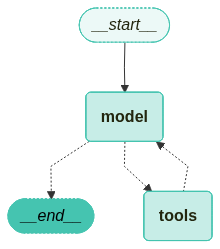

In [11]:
import os
from IPython.display import display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.agents import create_agent
from utils import format_messages
from langchain_teddynote.graphs import visualize_graph


# 웹 검색 도구 정의, 실제 검색 대신 모의 결과 반환
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """

    # 웹 검색 모의 결과 데이터
    search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로,
AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다.
이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 합니다.
본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다."""
    return search_result


# LLM 모델 초기화
model = init_chat_model(model="anthropic:claude-sonnet-4-5", temperature=0.0)

# 파일 도구 및 웹 검색 도구 리스트 생성, 에이전트에 전달
tools = [ls, read_file, write_file, web_search]

# 시스템 프롬프트와 상태 스키마 지정, 에이전트 생성
agent = create_agent(
    model, tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 에이전트의 내부 그래프 구조 시각화, Mermaid PNG로 출력
visualize_graph(agent)

## 실행 및 결과 확인

In [12]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Model Context Protocol (MCP) 의 개요에 대해서 설명하세요.",
            }
        ],
        "files": {},
    }
)

# 결과 확인
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP) 의 개요에 대해서 설명하세요.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 제가 Model Context Protocol (MCP)에 대해 조사하여 설명드리겠습니다.                                             │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_011AW6auJXWR49QWsnonPZUh                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "mcp_request.txt",                                                                               │
│   "content": "사용자 요청: Model Context Protocol (MCP)의 개요에 대해서 설명하세요.\n\n요청 날짜: 2024\n주제:   │
│ Model Context Protocol (MCP) 개요\n"                                                                            │
│ }                                                                                                               │
│    ID: toolu_01GgLKs4rKviUWz2T3HUajkC                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: toolu_01VZpPRFFcNuz5zeuaUzvykP                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["mcp_request.txt"]                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file mcp_request.txt                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로,                                        │
│ AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다.                │
│ 이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 │
│ 수 있도록 합니다.                                                                                               │
│ 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 어시스턴트를 외부 서비스에 연결하는 과정을      │
│ 단순화합니다.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_request.txt"                                                                                │
│ }                                                                                                               │
│    ID: toolu_01SyS1f7mUXwMzkPUun9XK8Z                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  사용자 요청: Model Context Protocol (MCP)의 개요에 대해서 설명하세요.                                   │
│      2                                                                                                          │
│      3  요청 날짜: 2024                                                                                         │
│      4  주제: Model Context Protocol (MCP) 개요                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) 개요                                                                            │
│                                                                                                                 │
│ **Model Context Protocol (MCP)**은 Anthropic이 개발한 **개방형 표준 프로토콜**입니다. 다음과 같은 특징을 가지고 │
│ 있습니다:                                                                                                       │
│                                                                                                                 │
│ ### 🎯 주요 목적                                                                                                │
│ - AI 모델과 외부 시스템(도구, 데이터베이스, 서비스 등) 간의 **원활한 통합**을 가능하게 합니다                   │
│ - AI 어시스턴트를 외부 서비스에 연결하는 과정을 **단순화**합니다                                                │
│                                                                                                                 │
│ ### 🔑 핵심 기능                                                                                                │
│ 1. **표준화된 통신 계층**: AI 모델과 외부 시스템 간의 일관된 통신 방식을 제공합니다                             │
│                                                                                                                 │
│ 2. **데이터 접근성**: AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근할 수 있도록 합니다       │
│                                                                                                                 │
│ 3. **통합 언어**: 데이터 교환을 위한 표준화된 언어를 제공하여 시스템 간 상호운용성을 향상시킵니다               │
│                                                                                                                 │
│ ### 💡 의의                                                                                                     │
│ MCP는 AI 생태계에서 **상호운용성**을 높이고, 개발자들이 AI 애플리케이션을 구축할 때 다양한 데이터 소스와 도구를 │
│ 더 쉽게 통합할 수 있도록 하는 표준 프레임워크를 제공합니다.                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

가상 파일 시스템에 파일이 정상적으로 저장된 것을 확인할 수 있습니다.  
이렇게 저장된 파일은 이후 에이전트가 필요할 때 언제든지 `read_file` 도구를 통해 내용을 조회하거나, 추가적인 정보를 기록하는 데 활용할 수 있습니다.  
이러한 파일 기반의 컨텍스트 관리 방식은 복잡한 작업 흐름에서도 중요한 정보를 안정적으로 보존하고, 에이전트의 메모리 사용을 효율적으로 최적화하는 데 큰 도움이 됩니다.

모의 파일 시스템에 파일이 저장된 것을 확인할 수 있습니다.

In [13]:
# 에이전트 실행 결과에서 가상 파일 시스템의 현재 상태(파일 목록 및 내용) 조회
result["files"]

{'mcp_request.txt': '사용자 요청: Model Context Protocol (MCP)의 개요에 대해서 설명하세요.\n\n요청 날짜: 2024\n주제: Model Context Protocol (MCP) 개요\n'}